In [1]:
import json
import numpy as np
import pandas as pd

import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# gensim
from gensim import corpora, models, similarities, matutils
# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


import preprocessor as p # 
import string # use string.punctuation to clean out punctuation

from pprint import pprint

from datetime import datetime
import pickle



from tqdm import tqdm

pd.set_option('display.max_colwidth', -1)

In [2]:
with open("clean_tweets_sample.pkl", 'rb') as picklefile: 
    sampleDF = pickle.load(picklefile)

In [3]:
with open("clean_tweets_full.pkl", 'rb') as picklefile: 
    fullDF = pickle.load(picklefile)

## Preprocessing

In [4]:
def just_text(tweetsDF):
    cleanDF = pd.DataFrame(columns = ['id','full_text'])
    cleanDF['full_text'] = tweetsDF['full_text']
    cleanDF.drop('id',axis = 1).head()
    return cleanDF

In [5]:
sampletextDF = just_text(sampleDF)

In [6]:
fulltextDF = just_text(fullDF)

# Set Stopwords

In [7]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop += ['climate', 'change', 'global', 'warming', 'climatechange', 'globalwarming']

## Count Vectorizer

In [18]:
def run_countvec(tweetDF):

    # Create a CountVectorizer for parsing/counting words
    count_vectorizer = CountVectorizer(ngram_range=(1, 2), #max_df = 0.8,  
                                   stop_words=stop, token_pattern="\\b[a-z][a-z]+\\b")
    count_vectorizer.fit(tweetDF.full_text)
    
    # Create the term-document matrix
    # Transpose it so the terms are the rows
    counts = count_vectorizer.transform(tweetDF.full_text).transpose()
    return count_vectorizer, counts

In [20]:
sample_count_vectorizer, sample_counts = run_countvec(sampletextDF)

In [32]:
full_count_vectorizer, full_counts = run_countvec(fulltextDF)

## TF-IDF

In [12]:
def run_tfidf(counts):
    transformer = TfidfTransformer(smooth_idf=False)
    x_tfidf = transformer.fit_transform(sample_counts)
    #xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)
    return x_tfidf

In [13]:
sample_tfidf = run_tfidf(sample_counts)

/Users/emilygeller/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1067: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(float(n_samples) / df) + 1.0


In [11]:
sample_counts.shape

(51177, 17579)

In [33]:
full_tfidf = run_tfidf(full_counts)

/Users/emilygeller/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1067: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(float(n_samples) / df) + 1.0


## NMF Topic Modelling

In [24]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import Normalizer

def run_nmf(num_topics, tfidf):
    nmf_model = NMF(num_topics)

    nmf = nmf_model.fit_transform(tfidf)
    nmf = Normalizer(copy=False).fit_transform(nmf)
    return nmf_model

In [26]:
sample_nmf_model = run_nmf(3, sample_tfidf)

In [34]:
full_nmf_model = run_nmf(3, full_tfidf)

In [21]:
def get_nmf_topics(model, n_top_words, count_vectorizer):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = count_vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-n_top_words - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [27]:
get_nmf_topics(sample_nmf_model, 10,sample_count_vectorizer)

,Topic # 01,Topic # 02,Topic # 03
0,children tm,controls weather,crop failures
1,climatescambs,controversial geoengineering,crisis could
2,da,bizarre,continue lost
3,cannot read,controversial right,confused
4,conversation,bj rn,concept better
5,control vomiting,energy engine,course water
6,controls biomass,far discussion,crossing
7,controls,check report,could tide
8,could rising,florida doctors,could words
9,could reduce,equates,continue plan


In [35]:
get_nmf_topics(full_nmf_model, 10,full_count_vectorizer)

,Topic # 01,Topic # 02,Topic # 03
0,blows,causes effects,check elainer
1,brits,causes enhanced,cause destabilization
2,christ way,australian vineyards,changed confusion
3,behind dont,causes decided,chick trans
4,causes might,author brings,chick
5,causes crop,cousteau,chester
6,causes death,degree higher,chemtrails messing
7,causes,blitz engineers,checkmates science
8,chance live,diabetes,checkmate
9,chance one,crude oil,chart family


In [28]:
def get_nmf_topics_freq(topic, model, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = count_vectorizer.get_feature_names()
    
    word_dict = {};
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
    freq = sorted(model.components_[topic])[:-n_top_words - 1: -1]
    
    words_ids = model.components_[topic].argsort()[:-n_top_words - 1:-1]
    words = [feat_names[key] for key in words_ids]
    
    for i in range(n_top_words):
        word_dict[words[i]] = freq[i]

    
    return word_dict

In [29]:
get_nmf_topics_freq(0,sample_nmf_model, 10)

{'cannot read': 0.0634840059982276,
 'children tm': 2.971584004320323,
 'climatescambs': 0.12687664154251474,
 'control vomiting': 0.0339107002870076,
 'controls': 0.0339107002870076,
 'controls biomass': 0.0339107002870076,
 'conversation': 0.0626547413836668,
 'could reduce': 0.024028678275698292,
 'could rising': 0.024028678275698292,
 'da': 0.09425726656705077}

In [119]:
np.argsort([3,0,1])[::-1]
sorted([3,0,1])[::-1]
([3,0,1]).sort()

In [30]:
sample_nmf_model.components_

array([[8.55160704e-05, 3.84107174e-04, 3.42351174e-04, ...,
        1.39872473e-04, 8.86341254e-05, 8.48496636e-05],
       [1.21642255e-04, 3.40970190e-04, 9.01159692e-04, ...,
        4.25937200e-04, 2.48976839e-04, 8.32613122e-05],
       [1.62379296e-04, 6.59544902e-04, 1.04341616e-02, ...,
        5.31291242e-04, 5.49984065e-04, 5.70380894e-03]])

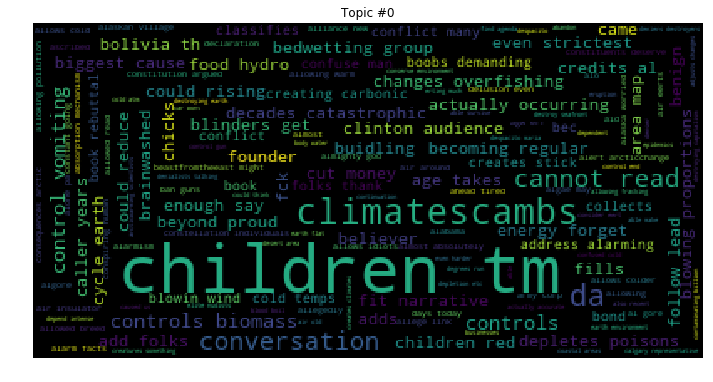

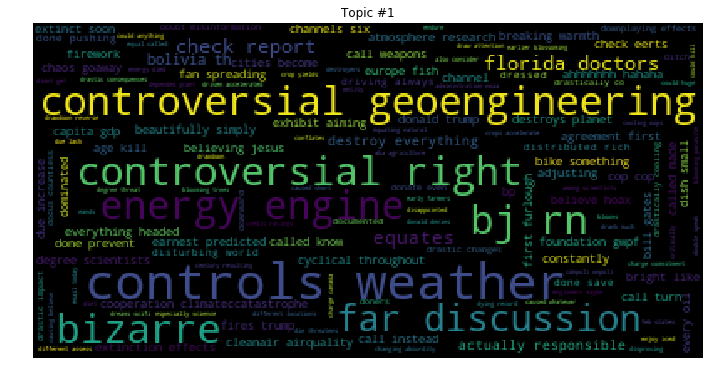

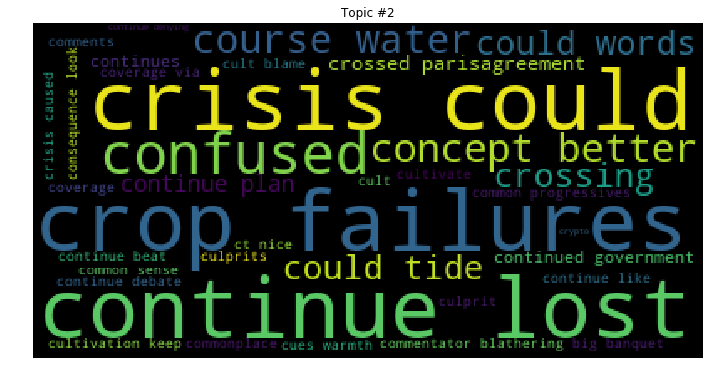

In [31]:
for t in range(num_topics):
    plt.figure(figsize = (12,16))
    plt.imshow(WordCloud().fit_words(dict(get_nmf_topics_freq(t, sample_nmf_model,200))))
    plt.axis('off')
    plt.title('Topic #' + str(t))
    plt.show();

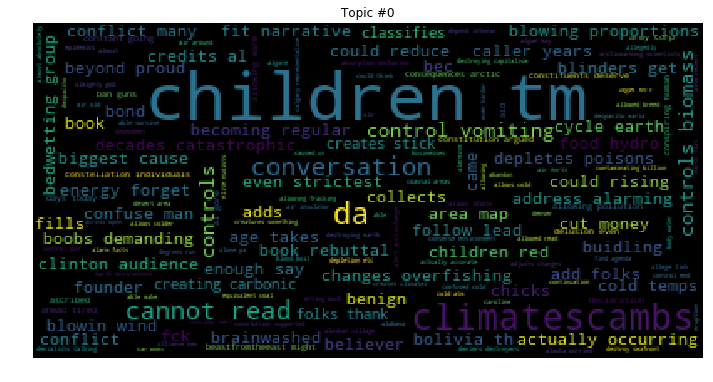

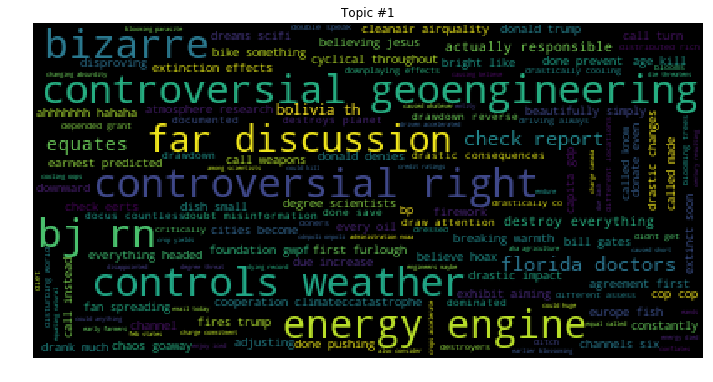

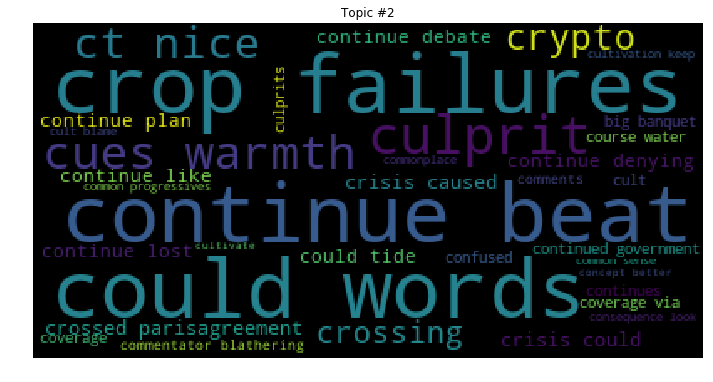

In [36]:
for t in range(num_topics):
    plt.figure(figsize = (12,16))
    plt.imshow(WordCloud().fit_words(dict(get_nmf_topics_freq(t, full_nmf_model,200))))
    plt.axis('off')
    plt.title('Topic #' + str(t))
    plt.show();

## Cluster